In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import warnings as wg
wg.filterwarnings("ignore") 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense, Activation, Dropout, RepeatVector
from tensorflow.keras.optimizers import  RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [3]:
#Loading the data
text = open('C:/Users/abhim/Downloads/1661-0.txt', encoding="utf8").read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [4]:
character = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(character))
indices_char = dict((i, c) for i, c in enumerate(character))
 
print(f'unique chars: {len(character)}')

unique chars: 73


In [5]:
seq_len = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - seq_len, step):
    sentences.append(text[i: i + seq_len ])
    next_chars.append(text[i + seq_len])
print(f'num training examples: {len(sentences)}')

num training examples: 193950


In [6]:
X = np.zeros((len(sentences), seq_len, len(character)), dtype=np.bool)
y = np.zeros((len(sentences), len(character)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

sentences[124]
next_chars[100]

'e'

In [7]:
X[0][0]


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True])

In [8]:
y[0]


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [9]:
X.shape


(193950, 40, 73)

In [10]:
y.shape


(193950, 73)

In [11]:
model = Sequential()
model.add(LSTM(500, input_shape=(seq_len, len(character))))
model.add(Dense(len(character)))
model.add(Activation('softmax'))

In [12]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 500)               1148000   
                                                                 
 dense (Dense)               (None, 73)                36573     
                                                                 
 activation (Activation)     (None, 73)                0         
                                                                 
Total params: 1,184,573
Trainable params: 1,184,573
Non-trainable params: 0
_________________________________________________________________


In [16]:
optimizer = RMSprop(learning_rate=0.5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y,
                    validation_split=0.01, 
                    batch_size=128,
                    epochs=5, 
                    shuffle=True).history

Epoch 1/5
1501/1501 [==============================] - 765s 508ms/step - loss: 38.2477 - accuracy: 0.0701 - val_loss: 57.4646 - val_accuracy: 0.0381
Epoch 2/5
1501/1501 [==============================] - 765s 510ms/step - loss: 37.0629 - accuracy: 0.0719 - val_loss: 55.0307 - val_accuracy: 0.0464
Epoch 3/5
1501/1501 [==============================] - 19264s 13s/step - loss: 37.4200 - accuracy: 0.0710 - val_loss: 56.3267 - val_accuracy: 0.0510
Epoch 4/5
1501/1501 [==============================] - 707s 471ms/step - loss: 37.6894 - accuracy: 0.0701 - val_loss: 60.5228 - val_accuracy: 0.0387
Epoch 5/5
1501/1501 [==============================] - 713s 475ms/step - loss: 38.1160 - accuracy: 0.0697 - val_loss: 55.6651 - val_accuracy: 0.0387


In [17]:
model.save('nextword.h5')
pickle.dump(history, open("history.p", "wb"))

In [18]:
model = load_model('nextword.h5')
history = pickle.load(open("history.p", "rb"))

In [19]:
loss_and_acc=model.evaluate(X,y)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

6061/6061 [==============================] - 666s 110ms/step - loss: 41.4346 - accuracy: 0.0466
Test Loss 41.43458557128906
Test Accuracy 0.04660994932055473


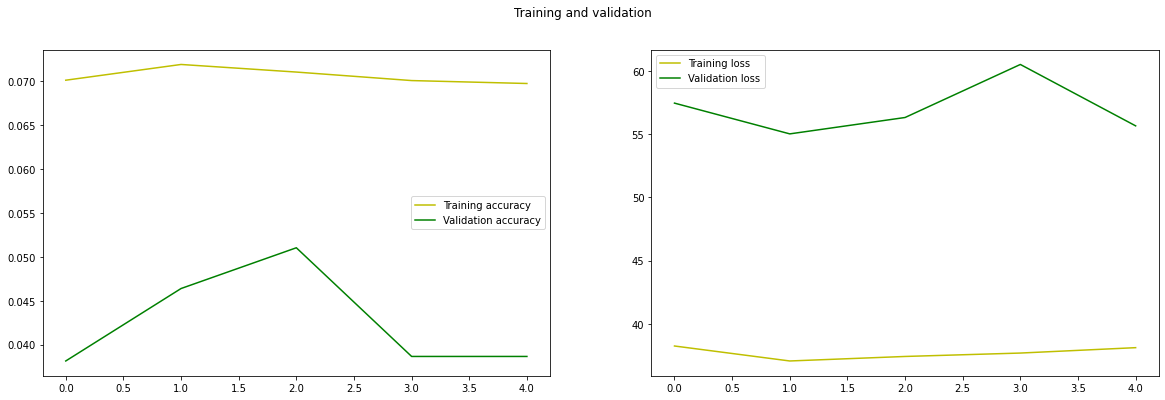

In [20]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'y', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'g', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'y', label='Training loss')
ax[1].plot(epochs, val_loss, 'g', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()


In [21]:
def prepare_input(text):
    x = np.zeros((1, seq_len, len(character)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

prepare_input("This is an example of input of our model".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [22]:

def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [24]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [25]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [26]:
quotes = [   
    "It is not a lack of  love, but a  lack of friendship that makes unhappy marriages.",
    "Recurrent neural network (RNN)is a type of artificial neural network which uses sequential data or time series data.",
    "Machine learning is the science of getting computers to act without being explicitly programmed.",
    "Deep learning is subset of machine learning,which is essentially a neural network with three or more layers.",
    "The goal of AI is to  make a  compter like humans to solve complex problems.",
    "Statistics are defined as numerical data, and is the field of math that deals with the collection, tabulation and interpretation of numerical data."
    ]

In [27]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of  love, but a  lack o
['sih\nh\nfrahoo ', '\nmhmouoinawky,aahinoma\nk\nss\nhhafwi\nmm\noh\nof ', 'yihm\nas\n\n\nofmcu\noawyhfd ', 'tihmuysaoemyhhur\no\n”,\nnhff\na ', 'h ']

recurrent neural network (rnn)is a type 
[' i\nhm\ndu\ndswhwhao\nda ', 'cihhffnnahpmblahwm ', 'fiuhi ', 'hnfhw\n\nu ', 'oiymewub\nrwh,beafanmh*hns\nho\n\ndcmulysoh\nt ']

machine learning is the science of getti
['wwhabf,ha\nwf\nasfue ', ' wh ', 'iwhacf\nthafltouptnhct\nnos\n,wimw ', 'hwhhmarehop\n,hai\n\n ', 'owhanf\nmau ']

deep learning is subset of machine learn
['otmnwahhdffuf ', 'hbff\ndha\nsnwph ', 'ctffnhhohm\nusue\nap\n\ns\nhanhhr\n,abyd ', 'utmfhcrhihs ', 'itfn ']

the goal of ai is to  make a  compter li
['f ', 'p ', '\nh\nrwhhiishorut ', 'wa\ny\nhsdhka” ', 'mh\nhwhff\n\nhhiwao\n\nkn\nrww\nhs\nbhmmoo ']

statistics are defined as numerical data
['\nsh\n½fn,\nfaanf\npaf ', 'fshf’a\nrfprk,r\nnyaayh“\ncewrhtiaf ', 'nsm\nlos’\nysupofmhnma\nuw\no\nhgaw\nhsam\nrnoi\n\n\nr\n,oh?;\n ', 'tr ', 